Problem Specifications
* Initial belief = 0.5, β = 0.9, I = 0.3
* f ∼ Beta(2, 5) and g ∼ Beta(2, 2)


1. Compute the optimal policy for infinite horizon
2. Simulate the optimal policy if true model is Beta(2, 2).
    1.estimate mean and std. deviation of investing timing with the optimal policy in 1

Computing the optimal policy

In [1]:
from scipy.stats import beta as β_distribution
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from scipy.interpolate import LinearNDInterpolator
from scipy.integrate import fixed_quad
from scipy.stats import beta as β_distribution


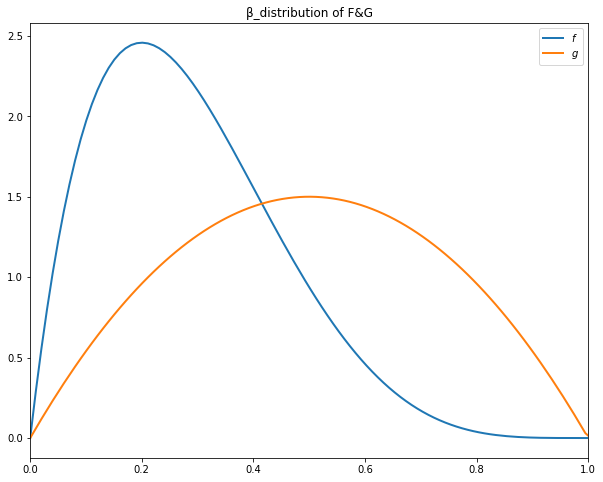

In [3]:
x = np.linspace(0, 2, 200)
plt.figure(figsize=(10, 8))
plt.plot(x, β_distribution.pdf(x, 2,5, scale=1), label='$f$', lw=2)
plt.plot(x, β_distribution.pdf(x, 2,2, scale=1), label='$g$', lw=2)
plt.xlim(0, 1)
plt.title("β_distribution of F&G", fontdict=None, loc='center')
plt.legend()
plt.show()

In [4]:
#Initializing grid space
π_grid = np.linspace(0, 1, 41)
w_grid = np.linspace(0, 1, 41)

In [5]:
β=0.9
I=0.3

w_max=1
w_grid_size=41
π_grid_size=41
F = β_distribution(2,5, scale=w_max)
G = β_distribution(2,2, scale=w_max)
f, g = F.pdf, G.pdf    # Density functions
π_min, π_max = 1e-3, 1 - 1e-3  # Avoids instability
w_grid = np.linspace(0, w_max, w_grid_size)
π_grid = np.linspace(π_min, π_max, π_grid_size)


In [6]:
#defining the bayesian probability function
def q(w, π):
        new_π = 1.0 / (1 + ((1 - π) * g(w)) / (π * f(w)))

        # Return new_π when in [π_min, π_max] and else end points
        new_π = np.maximum(np.minimum(new_π, π_max), π_min)

        return new_π

In [8]:
#Defining the policy function:
def res_operator(ξ):
        
        # == Turn ξ into a function == #
        ξ_f = lambda p: np.interp(p, π_grid, ξ)

        new_ξ = np.empty(len(ξ))
        for i, π in enumerate(π_grid):
            def integrand(x):
                "Integral expression on right-hand side of operator"
                return np.maximum(x, ξ_f(q(x, π))) * (π * f(x) + (1 - π) * g(x))
            integral, error = fixed_quad(integrand, 0, w_max)
            #proof derived in the class
            new_ξ[i] = (1 - β) * I + β * integral

        return new_ξ
    
    

To stop at some point, we take difference between new ξ and old ξ and at stop at time when the difference is less 1e-10

In [9]:
#finding the new values from the policy function using previous value
ξ = I*np.ones(len(π_grid))
ξ_old = ξ
loss_history = []
for i in range(50):
    ξ_new = res_operator(ξ_old)
    loss_history.append(np.abs(ξ_new-ξ_old).max())
    ξ_old = ξ_new
    if loss_history[-1]<=1e-10:
        break

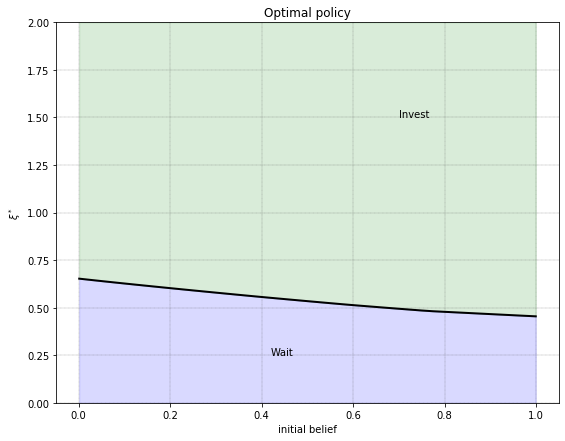

In [10]:
fig, ax = plt.subplots(figsize=(9, 7))
ax.plot(π_grid, ξ_new, linewidth=2, color='black')
ax.set_ylim(0, 2)
ax.grid(axis='x', linewidth=0.25, linestyle='--', color='0.25')
ax.grid(axis='y', linewidth=0.25, linestyle='--', color='0.25')
ax.fill_between(π_grid, 0, ξ_new, color='blue', alpha=0.15)
ax.fill_between(π_grid, ξ_new, 2, color='green', alpha=0.15)
ax.text(0.42, 0.25, 'Wait')
ax.text(0.7, 1.5, 'Invest')
ax.set_xlabel("initial belief")
ax.set_ylabel("$ξ^*$")
plt.title("Optimal policy")
plt.show()


The graph shows the with initial belif of 0.5 for G, we have wait till 0.7 values to invest. As the belief increases, the amount of time to wait to invest also decreases as the policy says we can recieve profit if we invest early.

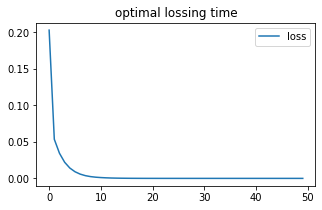

In [11]:
fig, ax1 = plt.subplots(figsize=(5, 3))
ax1.plot(loss_history,label="loss")
plt.title("optimal lossing time")
ax1.legend()

In [12]:
index=np.where(π_grid==0.5)[0][0]
print(ξ_new[index],loss_history[-1])

0.5343021885055017 7.77190534151373e-11


The answer for ξ∗(0.5) = 0.5343021885055017. 

Then the optimal policy for initial belief 0.5 is as follow:

    Π(ξ) = 
    * wait: ξ <= 0.5343021885055017, 
    * invest: ξ > 0.5343021885055017

### simulating optimal policy for T periods

In [13]:
T_max = 100 
ξ_star = lambda p: np.interp(p, π_grid, ξ_new)
def ForwardPass(π):
    steps = 0
    i = 0
    while i <= T_max:
        i = i+1
        ##initial distribution is assumed to be (2,2)
        w_sample = np.random.beta(2,2)
        π = q(w_sample,π)
        if w_sample >= ξ_star(π):
            steps = i
            break
    return steps

sample_size = 50
π_sizeNew = 31
π_gridNew = np.linspace(1e-3, 1 - 1e-3,π_sizeNew)
InvestTime = np.zeros((sample_size,len(π_gridNew)))

for ps,qs in enumerate(π_gridNew):
    for ss in range(sample_size):
        InvestTime[ss,ps] = ForwardPass(qs)

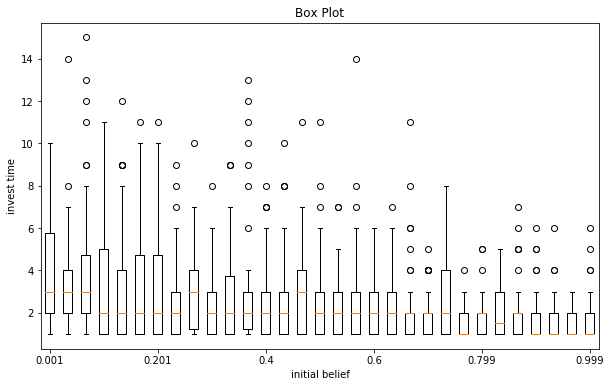

In [14]:
xlabel = np.linspace(1, π_sizeNew,int(π_sizeNew/5)).astype(int)
fig, ax = plt.subplots(figsize=(10,6))
ax.boxplot(InvestTime)
ax.set_title("Box Plot")
#ax.set_ylim(0,8)
ax.set_xlabel("initial belief")
ax.set_ylabel("invest time")
plt.xticks(xlabel,π_gridNew.round(3)[xlabel-1])
plt.show()

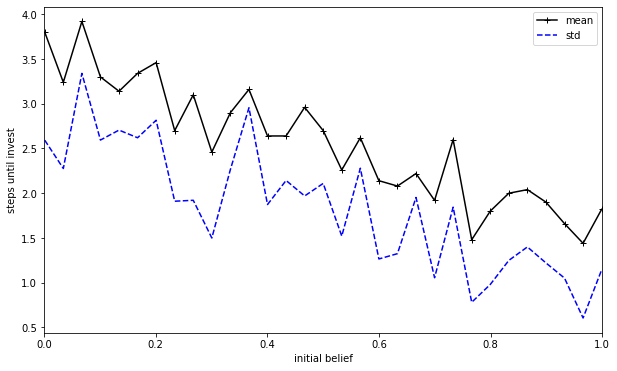

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(π_gridNew, InvestTime.mean(axis=0), '-+' ,color="black",label="mean")
ax.plot(π_gridNew, InvestTime.std(axis=0),'--', color="blue",label="std" )
ax.set_xlim(0,1)
ax.set_xlabel("initial belief")
ax.set_ylabel("steps until invest")
ax.legend()
plt.show()

As stated in the question, the true distribution is beta(2,2). 

When the initial belief is larger, the mean value time of investment is lower and std deviaiton of investment timing is lower. 

f_distribution is kind of distribution which points to earlier investment in time than compared g_distirbution. So with the true distribution being g_dist, at 0.5 intial belief and larger belief the mean value of investment timing goes lower

In [18]:
index=np.where(π_grid==0.5)[0][0]
print("mean:",InvestTime.mean(axis=0)[index],"STD. Deviation:",InvestTime.std(axis=0)[index])

mean: 2.22 STD. Deviation: 1.9523319389898837


the mean value of investment timing is 2.3 and the std. derivation is 1.6401219466856725.